In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# Function to load and process files based on the given conditions
def process_files(file_list, column_order, rename_dict, drop_column=None):
    dfs = []
    for file in file_list:
        df = pd.read_csv(file, delimiter=';', on_bad_lines='skip', dtype=str)
        if "Accident_Id" in df.columns:
            df.rename(columns={"Accident_Id": "Num_Acc"}, inplace=True)
        if drop_column and drop_column in df.columns:
            df.drop(columns=[drop_column], inplace=True)
        df = df.reindex(columns=column_order)
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.rename(columns=rename_dict, inplace=True)
    return combined_df

In [3]:
# Define file paths
source_folder = "source/"
caracteristiques_files = [os.path.join(source_folder, f) for f in os.listdir(source_folder) if f.startswith("caracteristiques")]
lieux_files = [os.path.join(source_folder, f) for f in os.listdir(source_folder) if f.startswith("lieux")]
usagers_files = [os.path.join(source_folder, f) for f in os.listdir(source_folder) if f.startswith("usagers")]
vehicules_files = [os.path.join(source_folder, f) for f in os.listdir(source_folder) if f.startswith("vehicules")]

In [4]:
# Define column orders and rename dictionaries
caracteristiques_columns = ["Num_Acc", "jour", "mois", "an", "hrmn", "lum", "dep", "com", "agg", "int", "atm", "col", "adr", "lat", "long"]
caracteristiques_rename = {"Num_Acc": "AccID", "jour": "day", "mois": "month", "an": "year", "hrmn": "time", "lum": "lum", 
                           "dep": "dep_code", "com": "com_code", "agg": "location", "int": "int", "atm": "atm_condition", 
                           "col": "collision_type", "adr": "address", "lat": "lat", "long": "long"}

lieux_columns = ["Num_Acc", "catr", "voie", "v1", "v2", "circ", "nbv", "vosp", "prof", "pr", "pr1", "plan", "lartpc", 
                 "larrout", "surf", "infra", "situ", "vma"]
lieux_rename = {"Num_Acc": "AccID", "catr": "route_category", "voie": "route_number", "v1": "route_number_index1", 
                "v2": "alph_route_index", "circ": "traffic_regime", "nbv": "total_number_lanes", "vosp": "reserved_lane_code", 
                "prof": "longitudinal_profile", "pr": "upstream_terminal_number", "pr1": "distance_upstream_terminal", 
                "plan": "plan", "lartpc": "width_central_reservation", "larrout": "width_roadway", "surf": "surface_condition", 
                "infra": "infra", "situ": "accident_situation", "vma": "maximum_speed"}

usagers_columns = ["Num_Acc", "id_vehicule", "num_veh", "place", "catu", "grav", "sexe", "an_nais", "trajet", "secu1", 
                   "secu2", "secu3", "locp", "actp", "etatp"]
usagers_rename = {"Num_Acc": "AccID", "id_vehicule": "vehicleID", "num_veh": "num_veh", "place": "seat", "catu": "user_category", 
                  "grav": "gravity", "sexe": "gender", "an_nais": "birth_year", "trajet": "reason_travel", "secu1": "safety_equipment1", 
                  "secu2": "safety_equipment2", "secu3": "safety_equipment3", "locp": "pedestrian_location", "actp": "pedestrian_action", 
                  "etatp": "pedestrian_involved"}

vehicules_columns = ["Num_Acc", "id_vehicule", "num_veh", "senc", "catv", "obs", "obsm", "choc", "manv", "motor", "occutc"]
vehicules_rename = {"Num_Acc": "AccID", "id_vehicule": "vehicleID", "num_veh": "num_veh", "senc": "traffic_direction", 
                    "catv": "vehicle_category", "obs": "fixed_obstacle", "obsm": "mobile_obstacle", "choc": "initial_impact_point", 
                    "manv": "manv", "motor": "motor", "occutc": "number_occupants_publictransport"}

In [5]:
# Process each group of files
characteristics = process_files(caracteristiques_files, caracteristiques_columns, caracteristiques_rename)
locations = process_files(lieux_files, lieux_columns, lieux_rename)
users = process_files(usagers_files, usagers_columns, usagers_rename, drop_column="id_usager")
vehicles = process_files(vehicules_files, vehicules_columns, vehicules_rename)

In [6]:
# Replace -1 to NaN
users['reason_travel'] = users['reason_travel'].replace(' -1', '0') # '-1 - Not specified' to '0 - Unknown'
characteristics.replace(' -1', np.nan, inplace=True)
locations.replace(' -1', np.nan, inplace=True)
users.replace(' -1', np.nan, inplace=True)
vehicles.replace(' -1', np.nan, inplace=True)

In [7]:
# Convert 'day', 'month', and 'year' fields to integer in the 'characteristics' dataframe
characteristics['day'] = pd.to_numeric(characteristics['day'], errors='coerce').astype(pd.Int64Dtype())
characteristics['month'] = pd.to_numeric(characteristics['month'], errors='coerce').astype(pd.Int64Dtype())
characteristics['year'] = pd.to_numeric(characteristics['year'], errors='coerce').astype(pd.Int64Dtype())


In [8]:
# Replace invalid literals with NaN and convert specified columns in 'locations' dataframe
locations['total_number_lanes'] = pd.to_numeric(locations['total_number_lanes'].replace('#ERREUR', np.nan), errors='coerce').astype(pd.Int64Dtype())
locations['maximum_speed'] = pd.to_numeric(locations['maximum_speed'], errors='coerce').astype(pd.Int64Dtype())
locations['upstream_terminal_number'] = pd.to_numeric(locations['upstream_terminal_number'], errors='coerce')
locations['distance_upstream_terminal'] = pd.to_numeric(locations['distance_upstream_terminal'], errors='coerce')

In [9]:
# Replace invalid literals with NaN and convert specified columns in 'users' dataframe
users['birth_year'] = pd.to_numeric(users['birth_year'], errors='coerce')

In [10]:
# Convert specified columns to object type
characteristics['lat'] = characteristics['lat'].str.replace(',', '.').astype(float)
characteristics['long'] = characteristics['long'].str.replace(',', '.').astype(float)

<font size="6">  
    Merge Dataframes
</font> 

In [11]:
# Merge DataFrames on AccID
data = characteristics.merge(locations, on='AccID', how='inner') \
                           .merge(vehicles, on='AccID', how='inner') \
                           .merge(users, on=['AccID', 'vehicleID', 'num_veh'], how='inner')

In [12]:
#Calculate 'age'
data['age'] = data['year'] - data['birth_year']

In [13]:
# Delete duplicate rows
data = data.drop_duplicates()

In [14]:
#Drop all columns where the proportion of NaN values is >= 0.30
data = data.loc[:, data.isna().sum() / len(data) < 0.30]

In [15]:
print(data.isna().sum() / len(data))

AccID                         0.000000
day                           0.000000
month                         0.000000
year                          0.000000
time                          0.000000
lum                           0.000020
dep_code                      0.000000
com_code                      0.000000
location                      0.000000
int                           0.000043
atm_condition                 0.000069
collision_type                0.007837
address                       0.012244
lat                           0.000000
long                          0.000000
route_category                0.000000
route_number                  0.096268
route_number_index1           0.178135
traffic_regime                0.053151
total_number_lanes            0.009684
reserved_lane_code            0.005753
longitudinal_profile          0.000160
upstream_terminal_number      0.237471
distance_upstream_terminal    0.240975
plan                          0.000124
surface_condition        

In [16]:
# Function to replace NaNs based on existing distribution
def fill_na_with_distribution(df, column):
    # Calculate value counts for non-NaN values
    value_counts = df[column].value_counts(normalize=True)
    
    # Create a list of values based on the distribution
    values = value_counts.index.tolist()
    probabilities = value_counts.values.tolist()
    
    # Number of NaNs to fill
    nans_to_fill = df[column].isna().sum()
    
    # Randomly choose values based on the distribution
    fill_values = np.random.choice(values, size=nans_to_fill, p=probabilities)
    
    # Fill NaNs with these values
    df.loc[df[column].isna(), column] = fill_values

# Apply the function to each column with NaN values
for column in data.columns:
    if data[column].isna().sum() > 0:
        fill_na_with_distribution(data, column)

pd.set_option('display.max_columns', None)
data.head(5)

,AccID,day,month,year,time,lum,dep_code,com_code,location,int,atm_condition,collision_type,address,lat,long,route_category,route_number,route_number_index1,traffic_regime,total_number_lanes,reserved_lane_code,longitudinal_profile,upstream_terminal_number,distance_upstream_terminal,plan,surface_condition,infra,accident_situation,maximum_speed,vehicleID,num_veh,traffic_direction,vehicle_category,fixed_obstacle,mobile_obstacle,initial_impact_point,manv,motor,seat,user_category,gravity,gender,birth_year,reason_travel,safety_equipment1,age
0,201900000001,30,11,2019,01:30,4,93,93053,1,1,1,2,AUTOROUTE A3,48.896210,2.470120,1,3,0,3,10,0,1,6.0,900.0,2,1,2,1,70,138 306 524,B01,2,7,0,2,5,23,1,2,2,4,2,2002.0,0,1,17.0
1,201900000001,30,11,2019,01:30,4,93,93053,1,1,1,2,AUTOROUTE A3,48.896210,2.470120,1,3,0,3,10,0,1,6.0,900.0,2,1,2,1,70,138 306 524,B01,2,7,0,2,5,23,1,1,1,4,2,1993.0,5,1,26.0
2,201900000001,30,11,2019,01:30,4,93,93053,1,1,1,2,AUTOROUTE A3,48.896210,2.470120,1,3,0,3,10,0,1,6.0,900.0,2,1,2,1,70,138 306 525,A01,2,17,1,0,3,11,1,1,1,1,1,1959.0,0,1,60.0
3,201900000002,30,11,2019,02:50,3,93,93066,1,1,1,6,AUTOROUTE A1,48.930700,2.368800,1,1,0,1,2,0,4,3.0,845.0,2,1,0,1,70,138 306 523,A01,1,7,4,0,1,0,1,1,1,4,2,1994.0,0,1,25.0
4,201900000003,28,11,2019,15:15,1,92,92036,1,1,1,4,AUTOROUTE A86,48.935872,2.319174,1,86,0,3,8,0,1,10.0,500.0,3,1,0,1,90,138 306 520,A01,1,7,0,2,1,2,1,1,1,1,1,1996.0,0,1,23.0


In [17]:
# IQR test
IQR_maximum_speed = data["maximum_speed"].quantile(0.75)-data["maximum_speed"].quantile(0.25)
# Lower bound
I1_maximum_speed = data["maximum_speed"].quantile(0.25) - 1.5 * IQR_maximum_speed

# Upper bound
I2_maximum_speed = data["maximum_speed"].quantile(0.75) + 1.5 * IQR_maximum_speed
print()
print("IQR :", IQR_maximum_speed, end="\n\n")
print("Range :[", I1_maximum_speed, ";", I2_maximum_speed, "]")
data.loc[(data['maximum_speed'] < 5) | (data['maximum_speed'] >125), 'maximum_speed']


IQR : 30.0

Range :[ 5.0 ; 125.0 ]


425       130
426       130
427       130
448       130
449       130
         ... 
494103    130
494104    130
494105    130
494106    130
494107    130
Name: maximum_speed, Length: 13712, dtype: Int64

In [18]:
# IQR test
IQR_age = data["age"].quantile(0.75)-data["age"].quantile(0.25)
# Lower bound
I1_age = data["age"].quantile(0.25) - 1.5 * IQR_age

# Upper bound
I2_age = data["age"].quantile(0.75) + 1.5 * IQR_age
print()
print("IQR :", IQR_age, end="\n\n")
print("Range :[", I1_age, ";", I2_age, "]")
data.loc[(data['age'] < 0) | (data['age'] >97), 'age']


IQR : 28.0

Range :[ -19.0 ; 93.0 ]


1718      119.0
2246       99.0
5588      118.0
5753      119.0
6146      118.0
          ...  
456468     99.0
468617    109.0
472018     98.0
485053    101.0
493936    100.0
Name: age, Length: 241, dtype: Float64

In [19]:
# Ensure the 'dep_code' column is numeric
data["dep_code"] = pd.to_numeric(data["dep_code"], errors='coerce')

# Drop any rows where 'dep_code' could not be converted to a numeric value
data = data.dropna(subset=["dep_code"])

# Calculate the IQR
IQR_dep_code = data["dep_code"].quantile(0.75) - data["dep_code"].quantile(0.25)

# Lower bound
I1_dep_code = data["dep_code"].quantile(0.25) - 1.5 * IQR_dep_code

# Upper bound
I2_dep_code = data["dep_code"].quantile(0.75) + 1.5 * IQR_dep_code

# Identify outliers
outliers = data[(data["dep_code"] < I1_dep_code) | (data["dep_code"] > I2_dep_code)]["dep_code"].unique()

# Print the IQR and bounds
print("IQR:", IQR_dep_code, end="\n\n")
print("Range: [", I1_dep_code, ";", I2_dep_code, "]")

# Print unique outlier values
print("\nUnique outlier values:")
print(outliers)

IQR: 53.0

Range: [ -45.5 ; 166.5 ]

Unique outlier values:
[988. 976. 974. 972. 973. 987. 986. 971. 977. 978. 975.]


In [20]:
# Remove outliers
data = data[~((data['maximum_speed'] < 5) | (data['maximum_speed'] > 125))]
data = data[~((data['age'] < 0) | (data['age'] > 93))]
data = data[~data['dep_code'].isin([988,976,974,972,973,987,986,971,977,978,975])]

In [21]:
# Dropping the specified columns
columns_to_exclude = ['dep_code', 'com_code', 'location', 'int', 'address', 'route_number_index1', 'route_number']
data = data.drop(columns=columns_to_exclude)


In [22]:
data['time'] = data['time'].apply(lambda x: (int(x.split(':')[0]) * 3600000) +
                                       (int(x.split(':')[1]) * 60000))

In [23]:
# Attempt to convert each column individually to identify which ones cause issues
problematic_columns = []

columns_to_convert = {
    'day': 'Int64',
    'month': 'Int64',
    'year': 'Int64',
    'time': 'Int64',
    'lum': 'Int64',
    'atm_condition': 'Int64',
    'collision_type': 'Int64',
    'lat': 'float64',
    'long': 'float64',
    'route_category': 'Int64',
    'traffic_regime': 'Int64',
    'total_number_lanes': 'Int64',
    'reserved_lane_code': 'Int64',
    'longitudinal_profile': 'Int64',
    'upstream_terminal_number': 'Int64',
    'distance_upstream_terminal': 'Int64',
    'plan': 'Int64',
    'surface_condition': 'Int64',
    'infra': 'Int64',
    'accident_situation': 'Int64',
    'maximum_speed': 'Int64',
    'traffic_direction': 'Int64',
    'vehicle_category': 'Int64',
    'fixed_obstacle': 'Int64',
    'mobile_obstacle': 'Int64',
    'initial_impact_point': 'Int64',
    'manv': 'Int64',
    'motor': 'Int64',
    'seat': 'Int64',
    'user_category': 'Int64',
    'gravity': 'Int64',
    'gender': 'Int64',
    'birth_year': 'Int64',
    'reason_travel': 'Int64',
    'safety_equipment1': 'Int64',
    'age': 'Int64'
}

for column, dtype in columns_to_convert.items():
    try:
        data[column].astype(dtype)
    except (ValueError, TypeError):
        problematic_columns.append(column)

problematic_columns


[]

In [24]:
# Identifying categorical columns in the dataset
categorical_columns = data.select_dtypes(include=['object', 'category', 'int64']).columns.tolist()

# Removing 'gravity' from the list as it will be the dependent variable
categorical_columns.remove('gravity')

# Initialize a dictionary to store the results
chi_square_results_all = {}

# Perform Chi-square test between 'gravity' and each categorical variable
for column in categorical_columns:
    contingency_table = pd.crosstab(data['gravity'], data[column])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    chi_square_results_all[column] = {
        'Chi-square statistic': chi2,
        'p-value': p,
        'Degrees of freedom': dof,
        'Expected frequencies': expected
    }

# Display the results
chi_square_results_all

{'AccID': {'Chi-square statistic': 636301.195411938,
  'p-value': 1.3873912875516578e-211,
  'Degrees of freedom': 601629,
  'Expected frequencies': array([[1.25775236, 0.41925079, 1.67700315, ..., 0.41925079, 1.25775236,
          0.83850157],
         [0.07557129, 0.02519043, 0.10076172, ..., 0.02519043, 0.07557129,
          0.05038086],
         [0.45452007, 0.15150669, 0.60602676, ..., 0.15150669, 0.45452007,
          0.30301338],
         [1.21215628, 0.40405209, 1.61620837, ..., 0.40405209, 1.21215628,
          0.80810418]])},
 'day': {'Chi-square statistic': 112.60572564106965,
  'p-value': 0.05367203507023035,
  'Degrees of freedom': 90,
  'Expected frequencies': array([[5969.71196194, 6147.05504501, 5913.95160721, 6114.77273438,
          6099.26045525, 6286.66555722, 6347.45692139, 6217.90842808,
          6336.55640092, 6221.26243438, 6260.6720084 , 6351.23017848,
          6327.75213438, 6264.86451627, 6244.32122769, 6370.5157147 ,
          6225.45494226, 6195.26888556,

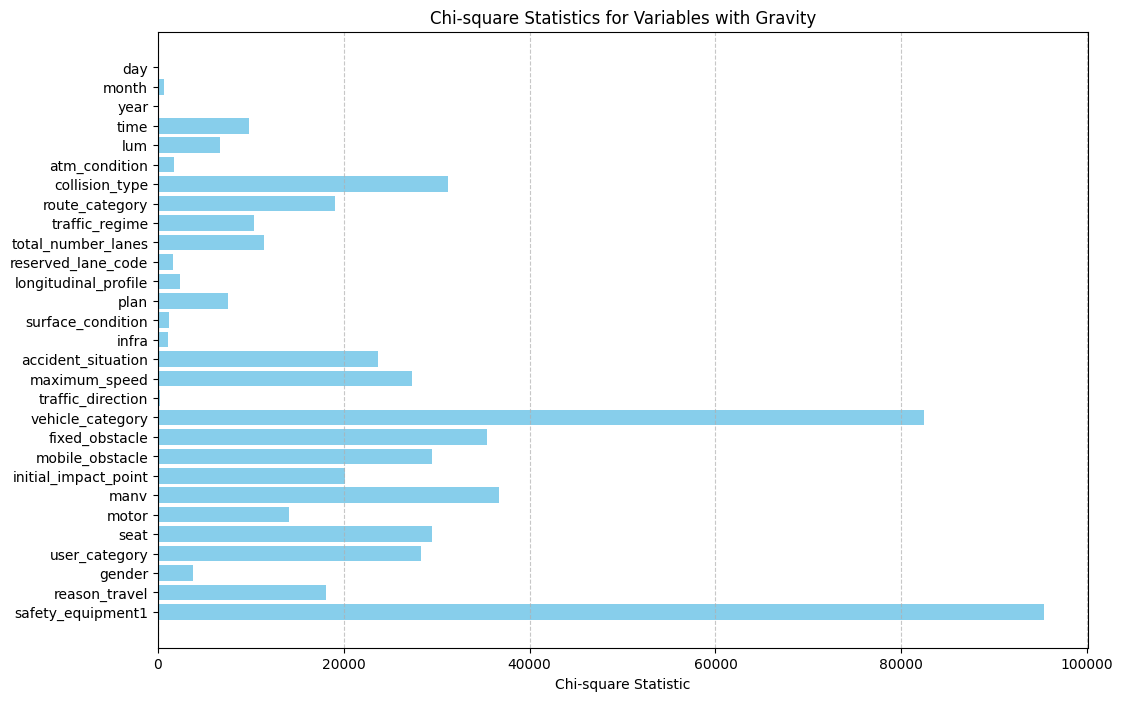

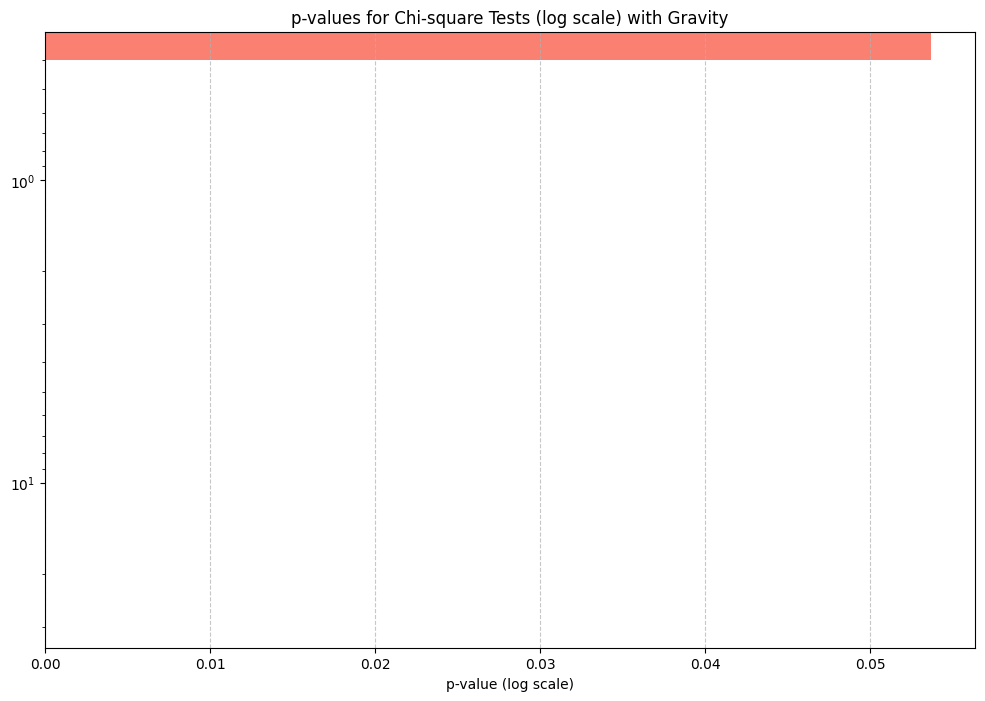

In [25]:
# Calculate Chi-square statistics for each categorical column
chi_square_results_all = {}
for column in categorical_columns:
    contingency_table = pd.crosstab(data['gravity'], data[column])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    chi_square_results_all[column] = {
        'Chi-square statistic': chi2,
        'p-value': p,
        'Degrees of freedom': dof,
        'Expected frequencies': expected
    }

# Extracting Chi-square statistics and p-values for visualization
variables = list(chi_square_results_all.keys())

# Exclude specific fields
exclude_fields = {'AccID', 'vehicleID', 'num_veh'}
filtered_variables = [var for var in variables if var not in exclude_fields]

# Extract the corresponding Chi-square statistics and p-values
filtered_chi_square_stats = [chi_square_results_all[var]['Chi-square statistic'] for var in filtered_variables]
filtered_p_values = [chi_square_results_all[var]['p-value'] for var in filtered_variables]

# Create a bar plot for Chi-square statistics
plt.figure(figsize=(12, 8))
plt.barh(filtered_variables, filtered_chi_square_stats, color='skyblue')
plt.xlabel('Chi-square Statistic')
plt.title('Chi-square Statistics for Variables with Gravity')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  
plt.show()

# Create a bar plot for p-values (log scale)
plt.figure(figsize=(12, 8))
plt.barh(filtered_variables, filtered_p_values, color='salmon')
plt.xlabel('p-value (log scale)')
plt.title('p-values for Chi-square Tests (log scale) with Gravity')
plt.yscale('log') 
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis() 
plt.show()

In [26]:
data.shape[0]

447670

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447670 entries, 0 to 494181
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AccID                       447670 non-null  object 
 1   day                         447670 non-null  Int64  
 2   month                       447670 non-null  Int64  
 3   year                        447670 non-null  Int64  
 4   time                        447670 non-null  int64  
 5   lum                         447670 non-null  object 
 6   atm_condition               447670 non-null  object 
 7   collision_type              447670 non-null  object 
 8   lat                         447670 non-null  float64
 9   long                        447670 non-null  float64
 10  route_category              447670 non-null  object 
 11  traffic_regime              447670 non-null  object 
 12  total_number_lanes          447670 non-null  Int64  
 13  reserved_lane_code 

<font size="6">  
    Export Dataframes
</font>  

In [28]:
data.to_csv('data.csv', index=False)